# Online Training Notebook

For this exercise, and given the particularities of the problem described, a quick PoC for an [Online training](https://en.wikipedia.org/wiki/Online_machine_learning) system has been built. This framework will allow to have evolving ML algorithms which will be "re-trained" on the fly, given a user input. 

Libraries like [RIVER](https://riverml.xyz/dev/) allow us to perform "stream training", which matches smoothly with this use case. 
In a nutshell, what we are attempting to do is re-create a simulated environment in which a set of tweets are displayed to the user according to a ranking score (calculated using a ML algorithm + heuristics). 

For example, a new batch of highly ranked tweets are shown to the user, a simulated method has been implemented to return whether the user interacts or not with a given tweet. This user feedback is automatically recorded re-trains the algorithm, updating its weights(without having to re-iterate through the whole training data set again ). Peformance metrics are tracked to monitor the models health, predictive power, evolution, convergence and drift.



In [21]:
# Imports
import sys
from copy import deepcopy

sys.path.append("/Users/e0449486/Desktop/text_analytics/")

from src.utils import DIR, read_data_input
from src.text_analytics import TextAnalytics
from src.online_model import OnlineTraining


In [22]:
# SET UPT
N_SIMS = 10  # we will save some samples for the simulation demo

# Loading the Data and the Online Modelling Pipe

In [23]:

# load the data
df = read_data_input(DIR)
# Simulation Data Set -> Used for the online learning

# Launch The text analytics Pipelineç
# Build the training set using the TextAnalytics pipe
training_df = TextAnalytics(df.iloc[ : -N_SIMS]).predictive_df

# Build a sim dataset using the same pipe
sim_df = TextAnalytics(df.iloc[- N_SIMS : ]).predictive_df

In [24]:
# Launch the online modelling class
online_model = OnlineTraining(
    training_df
)

# Model Training and Validation

Here, it can be seen that the model is training and it's performance is evolving through time, as it can be seen in the lineplots below. It's also visible how the test set, not only evaluates the model, but also trains it on the fly too. In our exercise, a simple Logistic-regression-based Model Stack has been selected [Model Stacks](https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/), with the ROCAUC performance metric as the KPI to follow.  This model, although simple, is quite efficient, has high explainability and could be an interesting choice to perform rankings for millions of users as described in the use case.

A valid point in this type of learning is to highlight that there is no need of having a separate testing set if the model is trained through streams. This is certainly true, however in this example I have included a testing set for two main reasons: One, demonstrating the constant stream learning flow (seen with the ROCAUC evolution); and second, to keep the traditional ML experimentation workflow.

ROC AUC: ROCAUC: 72.70%
Confusion Matrix
    0     1    
0   101    55  
1    55   106  
------------------------------


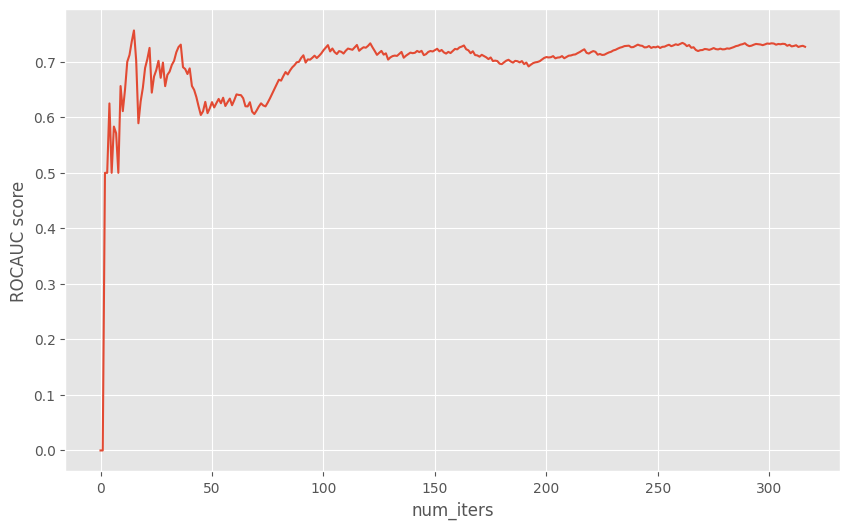

ROC AUC After Test Set learning: ROCAUC: 74.39%
Confusion Matrix
    0     1    
0   149    75  
1    75   155  
------------------------------


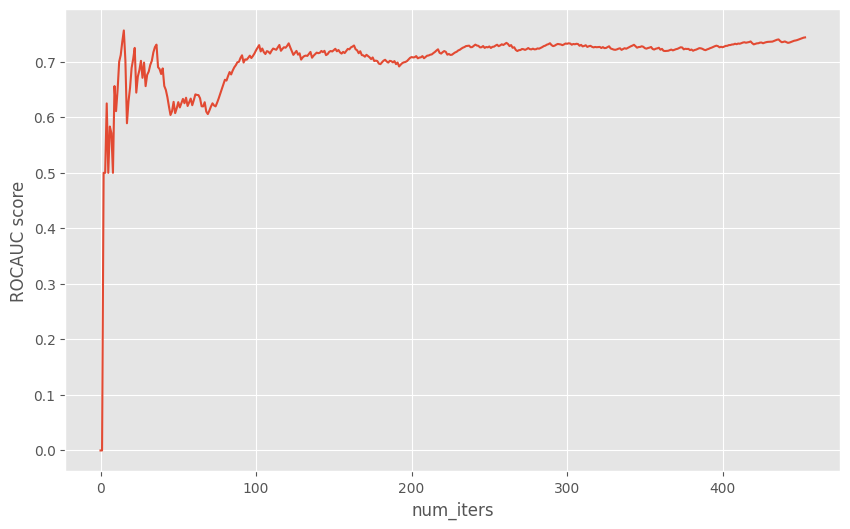

In [25]:
online_model.train_online_model()

### The Recommended Tweets accoring to the Acceptence probability are recorded in the online_model.recommended attribute. The OnlineTraining class built for this use case outputs a list of the highest ranked tweets. By default, the list only outputs 20 recommended tweets, but it can be configured as a class parameter

In [26]:
online_model.recommended

{706579: 0.9878254753605958,
 860185: 0.9873463065274443,
 574667: 0.9872200978568636,
 951641: 0.9865039703271344,
 143208: 0.9863649298560437,
 337267: 0.9828942163671827,
 546675: 0.9760953677502909,
 786621: 0.9747208812996748,
 475278: 0.9738209141266936,
 866306: 0.9724541843610127,
 735896: 0.9648210729803112,
 483481: 0.9640533801713441,
 262567: 0.9637857465998635,
 855197: 0.9608519494636688,
 178326: 0.9603585541704162,
 303073: 0.9597161866513017,
 230291: 0.9575026824456888,
 314972: 0.9557246762169092,
 457920: 0.9551754331659605,
 297252: 0.9551422960864724}

In [27]:
# We save the Reco at Train to see how it evolves in the future
reco_at_train = deepcopy(online_model.recommended)

# Simulating User input

With the model trained and a successful evaluation performed we can do a simple simulated exercise in which we will recreate a user experience in the app. 

The logic is simple, a tweet is presented, the reaction recorded (accepted or rejected), the model re-trained and the recommendations reformulated.

In [28]:
# Let's see the first tweet in the dataset
sim_df.iloc[0].label

'rejected'

In [29]:
# pretend user interacted with the tweet
# and rejected the tweet 
# (in this case we a priori now this as the dataset is labelled)
# but the logic still remains, the weights are updated with the new stream
online_model._return_fake_user_input = 0  # 0 == rejection


Tweet ID 618075
{False: 0.3906256581956654, True: 0.6093743418043346}
ROC AUC After Test Set learning: ROCAUC: 74.31%
Confusion Matrix
    0     1    
0   149    76  
1    75   155  
------------------------------


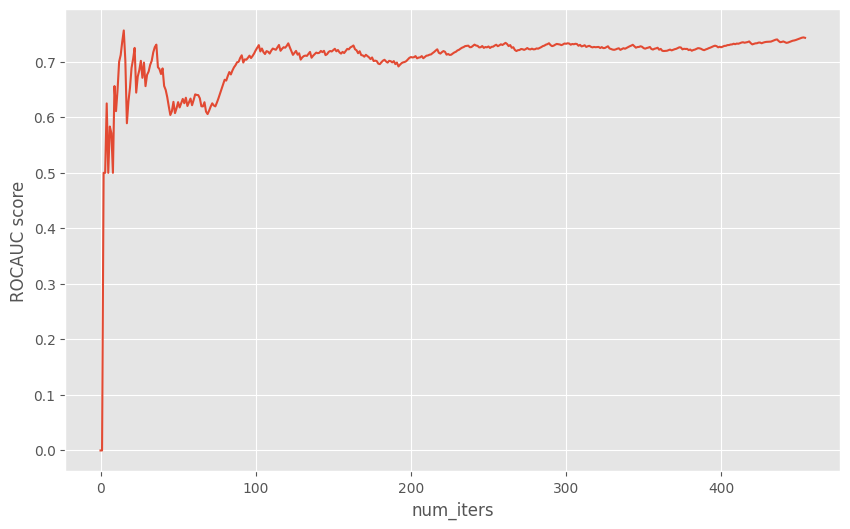

In [30]:
# Here the tweet is presented and the user input recorded
online_model.new_entry(
    sim_df.drop('label', axis=1).iloc[0]
)

In this case, the model would have predicted an "acceptance", however it would have been wrong. The input is given, the model learns and the performance metrics updated. 

**Second Tweet Interaction**

In [31]:
# Here the user accepted the tweet
sim_df.iloc[1].label

'accepted'

Tweet ID 560724
{False: 0.5448669009273108, True: 0.4551330990726891}
ROC AUC After Test Set learning: ROCAUC: 74.28%
Confusion Matrix
    0     1    
0   149    76  
1    76   155  
------------------------------


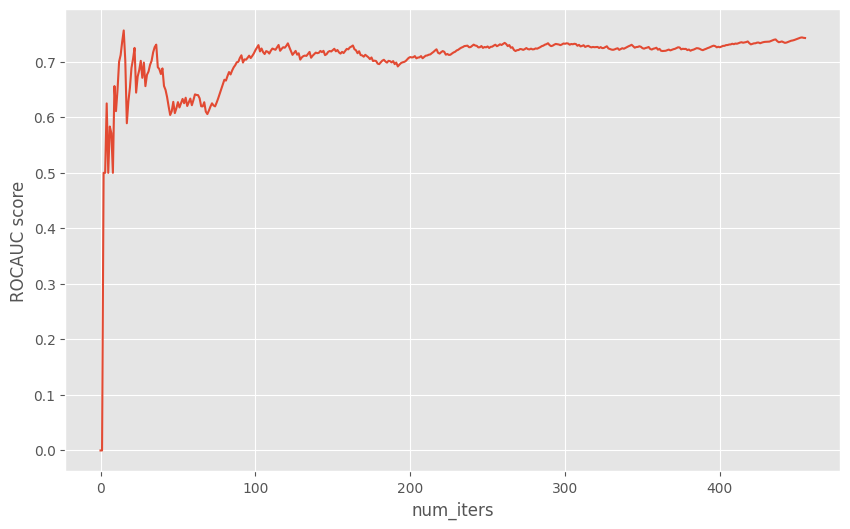

In [32]:
# the setter of the method allows us to set it as 1 or 0 smoothly
online_model._return_fake_user_input = 1  # pretend user interacted with the tweet
# Again tweet is presented to the user, interaction updates the weights
# in this case, the model fails again
online_model.new_entry(
    sim_df.drop('label', axis=1).iloc[1]
)

## We continue doing simulations with the same logic, updating the weights on the fly

In [33]:

sim_df.iloc[2].label

'accepted'

Tweet ID 149876
{False: 0.1122485953227167, True: 0.8877514046772833}
ROC AUC After Test Set learning: ROCAUC: 74.36%
Confusion Matrix
    0     1    
0   149    76  
1    76   156  
------------------------------


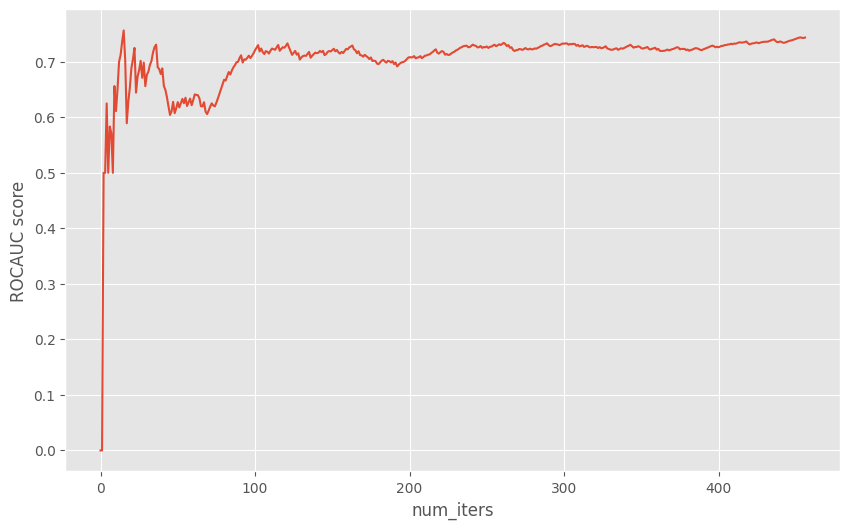

In [34]:
online_model._return_fake_user_input = 1  # pretend user interacted with the tweet

online_model.new_entry(
    sim_df.drop('label', axis=1).iloc[2]
)

In [35]:

sim_df.iloc[7].label

'rejected'

Tweet ID 942649
{False: 0.05137439386547049, True: 0.9486256061345295}
ROC AUC After Test Set learning: ROCAUC: 74.47%
Confusion Matrix
    0     1    
0   149    76  
1    76   157  
------------------------------


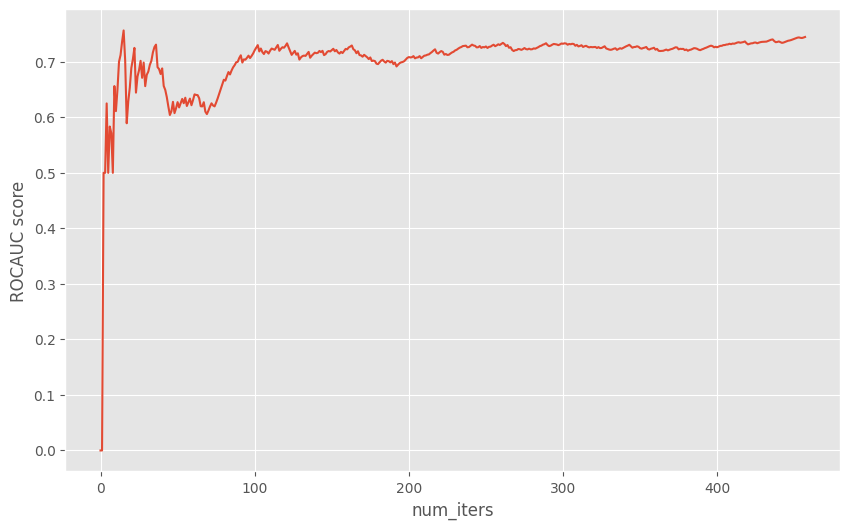

In [36]:
online_model._return_fake_user_input = 1  # pretend user interacted with the tweet

online_model.new_entry(
    sim_df.drop('label', axis=1).iloc[4]
)

## Working with very similar tweets

As a final simulation exercise, let's pretend we have a very similar set of tweets which have a high engagement interaction with the user. This would mimic a conversation or a topic in which the user is highly active, updating the recommendation and boosting these type of tweets higher and higher in the ranking

Tweet ID 427187
{False: 0.0743868761904013, True: 0.9256131238095987}
ROC AUC After Test Set learning: ROCAUC: 74.57%
Confusion Matrix
    0     1    
0   149    76  
1    76   158  
------------------------------


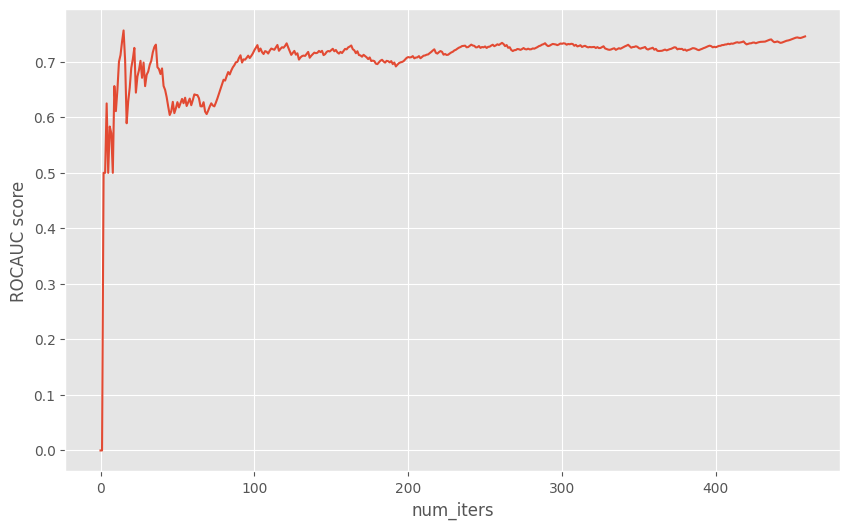

Tweet ID 954634
{False: 0.02312346298818657, True: 0.9768765370118134}
ROC AUC After Test Set learning: ROCAUC: 74.67%
Confusion Matrix
    0     1    
0   149    76  
1    76   159  
------------------------------


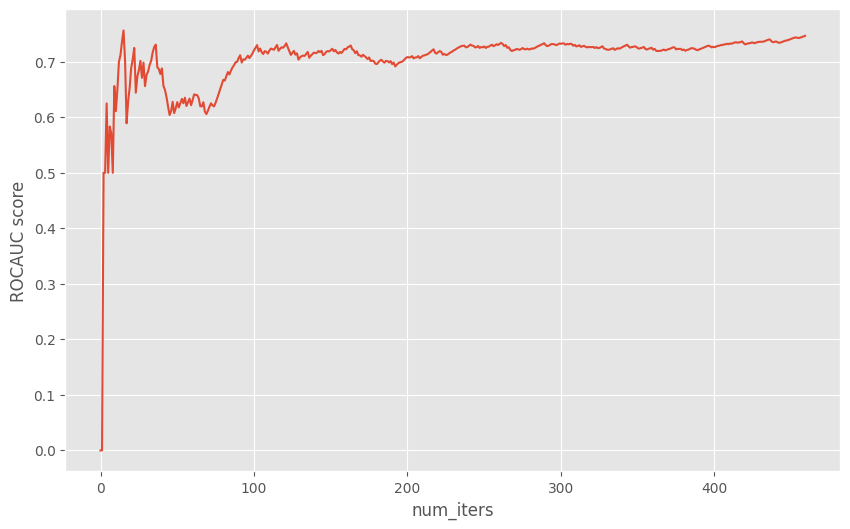

Tweet ID 657348
{False: 0.017988635445477796, True: 0.9820113645545222}
ROC AUC After Test Set learning: ROCAUC: 74.77%
Confusion Matrix
    0     1    
0   149    76  
1    76   160  
------------------------------


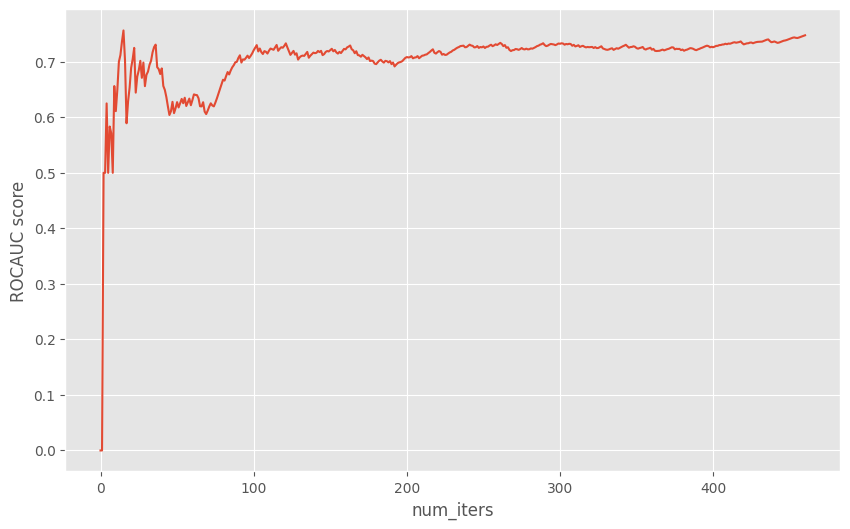

Tweet ID 312263
{False: 0.01562988258085274, True: 0.9843701174191473}
ROC AUC After Test Set learning: ROCAUC: 74.87%
Confusion Matrix
    0     1    
0   149    76  
1    76   161  
------------------------------


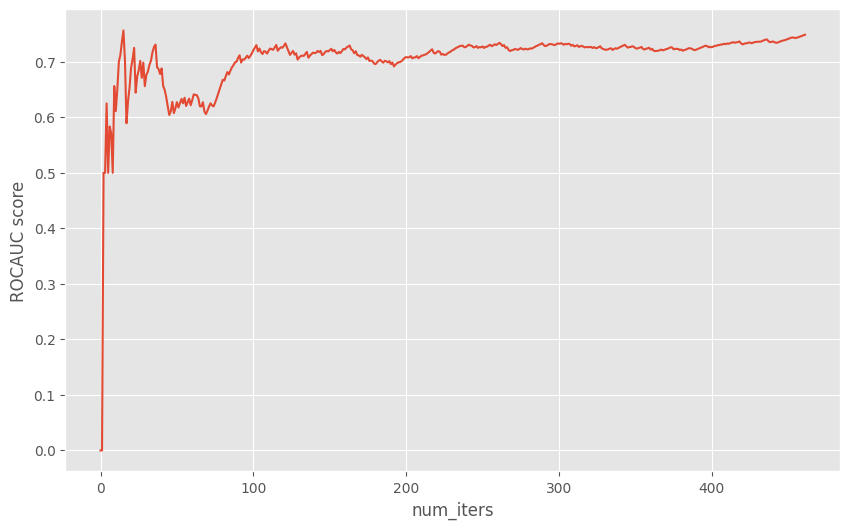

Tweet ID 410999
{False: 0.014231943979888029, True: 0.985768056020112}
ROC AUC After Test Set learning: ROCAUC: 74.97%
Confusion Matrix
    0     1    
0   149    76  
1    76   162  
------------------------------


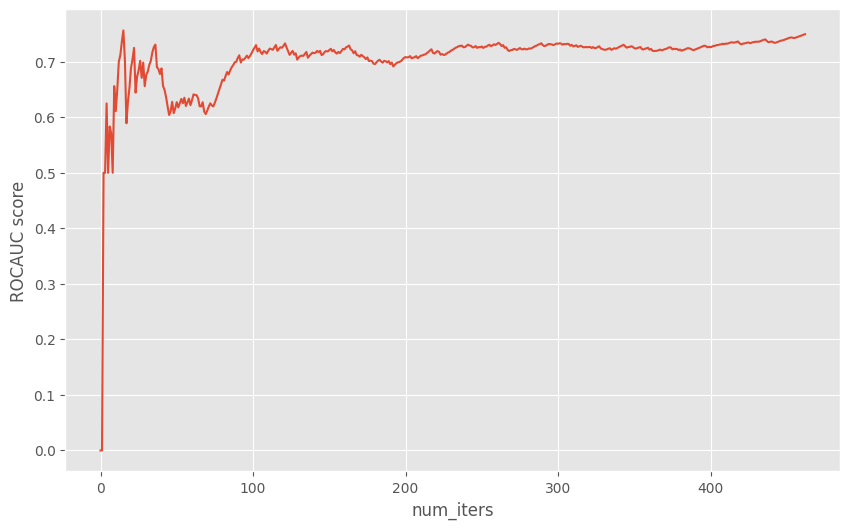

Tweet ID 812014
{False: 0.0132836438348517, True: 0.9867163561651483}
ROC AUC After Test Set learning: ROCAUC: 75.07%
Confusion Matrix
    0     1    
0   149    76  
1    76   163  
------------------------------


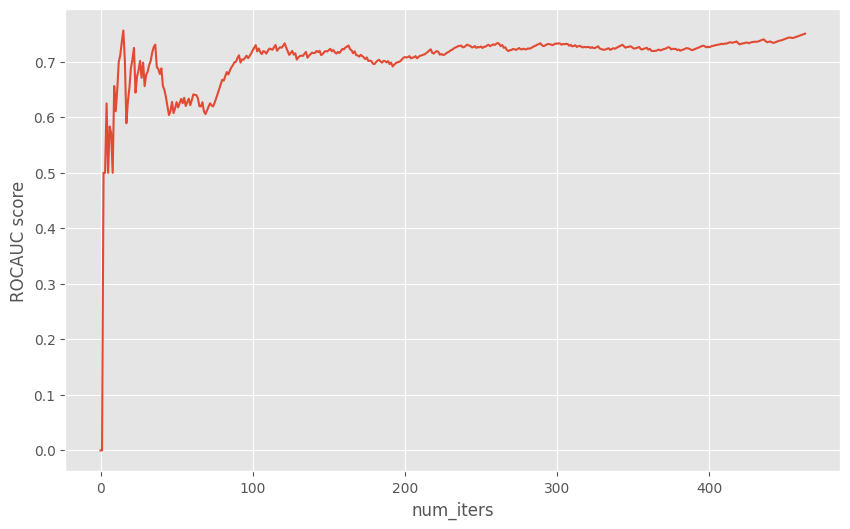

Tweet ID 203304
{False: 0.012583857125161413, True: 0.9874161428748386}
ROC AUC After Test Set learning: ROCAUC: 75.17%
Confusion Matrix
    0     1    
0   149    76  
1    76   164  
------------------------------


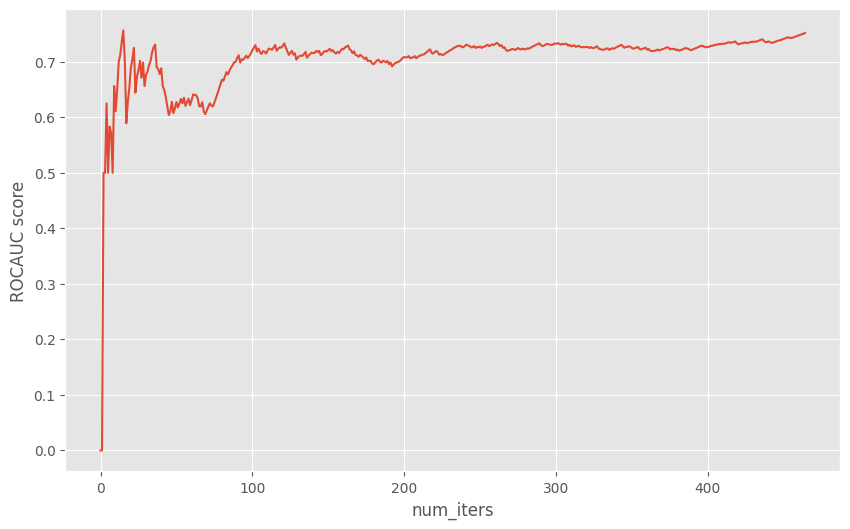

Tweet ID 147298
{False: 0.01203711963890619, True: 0.9879628803610938}
ROC AUC After Test Set learning: ROCAUC: 75.26%
Confusion Matrix
    0     1    
0   149    76  
1    76   165  
------------------------------


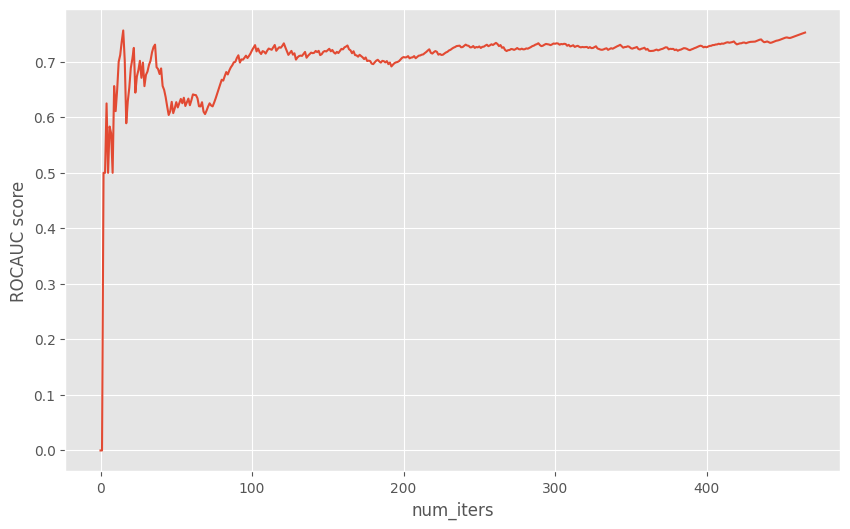

Tweet ID 617061
{False: 0.011592156641782259, True: 0.9884078433582177}
ROC AUC After Test Set learning: ROCAUC: 75.36%
Confusion Matrix
    0     1    
0   149    76  
1    76   166  
------------------------------


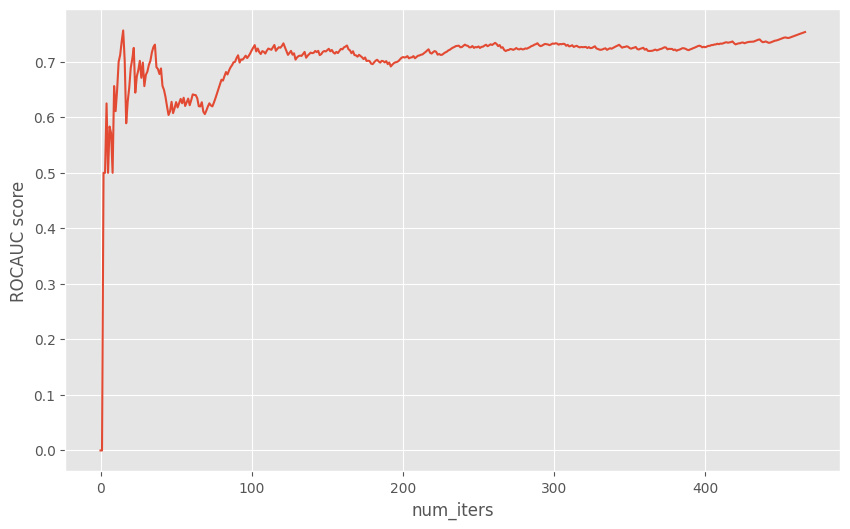

Tweet ID 249422
{False: 0.011218873921102324, True: 0.9887811260788977}
ROC AUC After Test Set learning: ROCAUC: 75.45%
Confusion Matrix
    0     1    
0   149    76  
1    76   167  
------------------------------


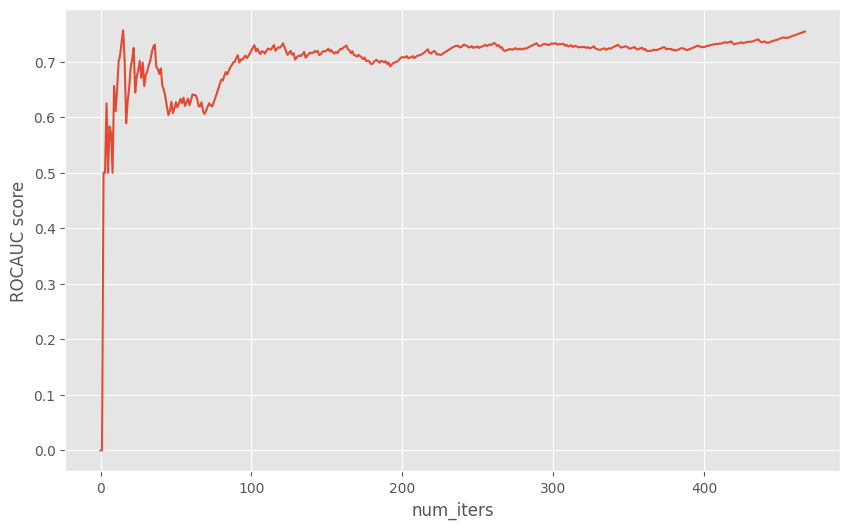

In [37]:
# Force a high interaction with very similar tweets
online_model._return_fake_user_input = 1  # pretend user interacted with the tweet
similar_tweets = sim_df.drop('label', axis=1).iloc[4]
for i in range(10):  # we build 10 very similar, almost identical tweeets
    if 'tweet_id' in similar_tweets.keys():
        similar_tweets = similar_tweets.drop('tweet_id')
        
    similar_tweets += 0.0001 # slight change in all cols
    online_model.new_entry(
        similar_tweets  
    )


### Here it is fascinating to see that the probability of acceptance keeps on growing and growing for these type of tweets, as the user is constantly engaged by this particular conversation or topic. Finally, we can see that the recommended tweets dictionray has in fact been updated. 

In [38]:
import operator
sorted(
    online_model.recommended.items(),
    key=operator.itemgetter(1),
    reverse=True
)

[(249422, 0.9887811260788977),
 (617061, 0.9884078433582177),
 (147298, 0.9879628803610938),
 (706579, 0.9878254753605958),
 (203304, 0.9874161428748386),
 (860185, 0.9873463065274443),
 (574667, 0.9872200978568636),
 (812014, 0.9867163561651483),
 (951641, 0.9865039703271344),
 (143208, 0.9863649298560437),
 (410999, 0.985768056020112),
 (312263, 0.9843701174191473),
 (337267, 0.9828942163671827),
 (657348, 0.9820113645545222),
 (954634, 0.9768765370118134),
 (546675, 0.9760953677502909),
 (786621, 0.9747208812996748),
 (475278, 0.9738209141266936),
 (866306, 0.9724541843610127),
 (735896, 0.9648210729803112),
 (483481, 0.9640533801713441),
 (262567, 0.9637857465998635),
 (855197, 0.9608519494636688),
 (178326, 0.9603585541704162),
 (303073, 0.9597161866513017),
 (230291, 0.9575026824456888),
 (314972, 0.9557246762169092),
 (457920, 0.9551754331659605),
 (297252, 0.9551422960864724)]

In [39]:
online_model.recommended.keys() - reco_at_train.keys()

{147298, 203304, 249422, 312263, 410999, 617061, 657348, 812014, 954634}

End of File

In [40]:
%load_ext watermark
%watermark -n -u -v -iv -w

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Sat May 20 2023

Python implementation: CPython
Python version       : 3.9.16
IPython version      : 8.13.2

sys: 3.9.16 (main, Mar  8 2023, 04:29:44) 
[Clang 14.0.6 ]

Watermark: 2.3.1

